In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
%matplotlib inline



KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Students: Ali Raza, Theresa Seidl, Diane Seibert, Maria, Soufiane.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
#!ls kaggle

In [3]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

In [4]:
#!head ./kaggle/train_set.csv

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [5]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [6]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [7]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [8]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    

    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        # Checks if this file exists and if not download it
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path) 
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

Let's define a function to plot the sequence of images

In [9]:
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

We implement HAARPreprocessor on our training and testing data

In [10]:
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)

We use our plotting function to visualize our processed images

This will allow use to see if faces were extracted well from our raw images

In [ ]:
plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)


As we can see above, the faces extracted using HAARPreprocessor are not ideal

We can see 3 problems:
 - In some images a different face (not corresponding to class was extracted)
 - In some images no face was detected, and we got a blank image (all black)
 - In some images some other part of the image was wrongly extracted as the face (e.g. Jesse's hair or shirt)

Let's create a class to plot the raw images so we can visualize them and see what is the problem

In [12]:
class raw_images():

    def preprocess(self, data_row):
        return cv2.resize(data_row['img'], (600,600), interpolation = cv2.INTER_AREA)
    
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

In [ ]:
preprocessor_raw = raw_images()

raw_X, raw_y = preprocessor_raw(train), train['class'].values

plot_image_sequence(raw_X[raw_y == 0], n=20, imgs_per_row=10)

plot_image_sequence(raw_X[raw_y == 1], n=30, imgs_per_row=10)

plot_image_sequence(raw_X[raw_y == 2], n=30, imgs_per_row=10)

We can see that in some images, there is more than one person and HAARProcessor only extracts the first face (faces[0])

We therefore should try to improve our HAARProcessor

We will create HAARProccesor_V2_train to extract all faces from the training images

For the images in which we have more than one face, we will extract all of them and give them the class label of the image

We can later correct the class of those faces in later stages

We also improve the detection of images (in detect_faces()) by trying different parameters if no face was detected in order to avoid extracting no face at all 

In [14]:
class HAARPreprocessor_V2_train():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=8,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
        if len(faces)==0: # if no faces found, try different parameters
            faces = self.classifier.detectMultiScale(
                img_gray,
                scaleFactor=1.2,
                minNeighbors=1,
                minSize=(30, 30),
                flags=cv2.CASCADE_SCALE_IMAGE
                )
            if len(faces)==0: # if no faces found still, try other parameters
                faces = self.classifier.detectMultiScale(
                    img_gray,
                    scaleFactor=1.1,
                    minNeighbors=1,
                    minSize=(30, 30),
                    flags=cv2.CASCADE_SCALE_IMAGE
                    )
        return faces
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):  
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return [nan_img]
        
        # return a list of all faces detected
        return [cv2.resize(face, self.face_size, interpolation = cv2.INTER_AREA) for face in faces] 

            
    def __call__(self, data):
        output_faces =  np.array([])
        labels = data['class']
        for idx, row in data.iterrows():
            lbl=labels[idx] # keep track of correct labels
            for i in range(len(self.preprocess(row))): # concatenate all faces
                if np.all(output_faces==0):
                    output_faces=self.preprocess(row)[i]
                    new_labels=[lbl]
                else:
                    output_faces=np.concatenate((output_faces, self.preprocess(row)[i]), axis=0).astype(int)
                    new_labels.append(lbl)
        new_labels=np.array(new_labels) 
        n_faces = int((output_faces.shape[0])/100)
        output_faces = output_faces.reshape(n_faces,100,100,3)
        return output_faces, new_labels # return processed images and corresponding class labels 

We implement our improved HAARProcessor

In [15]:
# Use the improved HaarProcessor

FACE_SIZE = (100,100)
preprocessor_train = HAARPreprocessor_V2_train(path = '../../tmp', face_size=FACE_SIZE)

train_X_V2, train_y_V2 = preprocessor_train(train)

We plot the images extracted with the improved HAARProcessor and we see that we extracted more faces

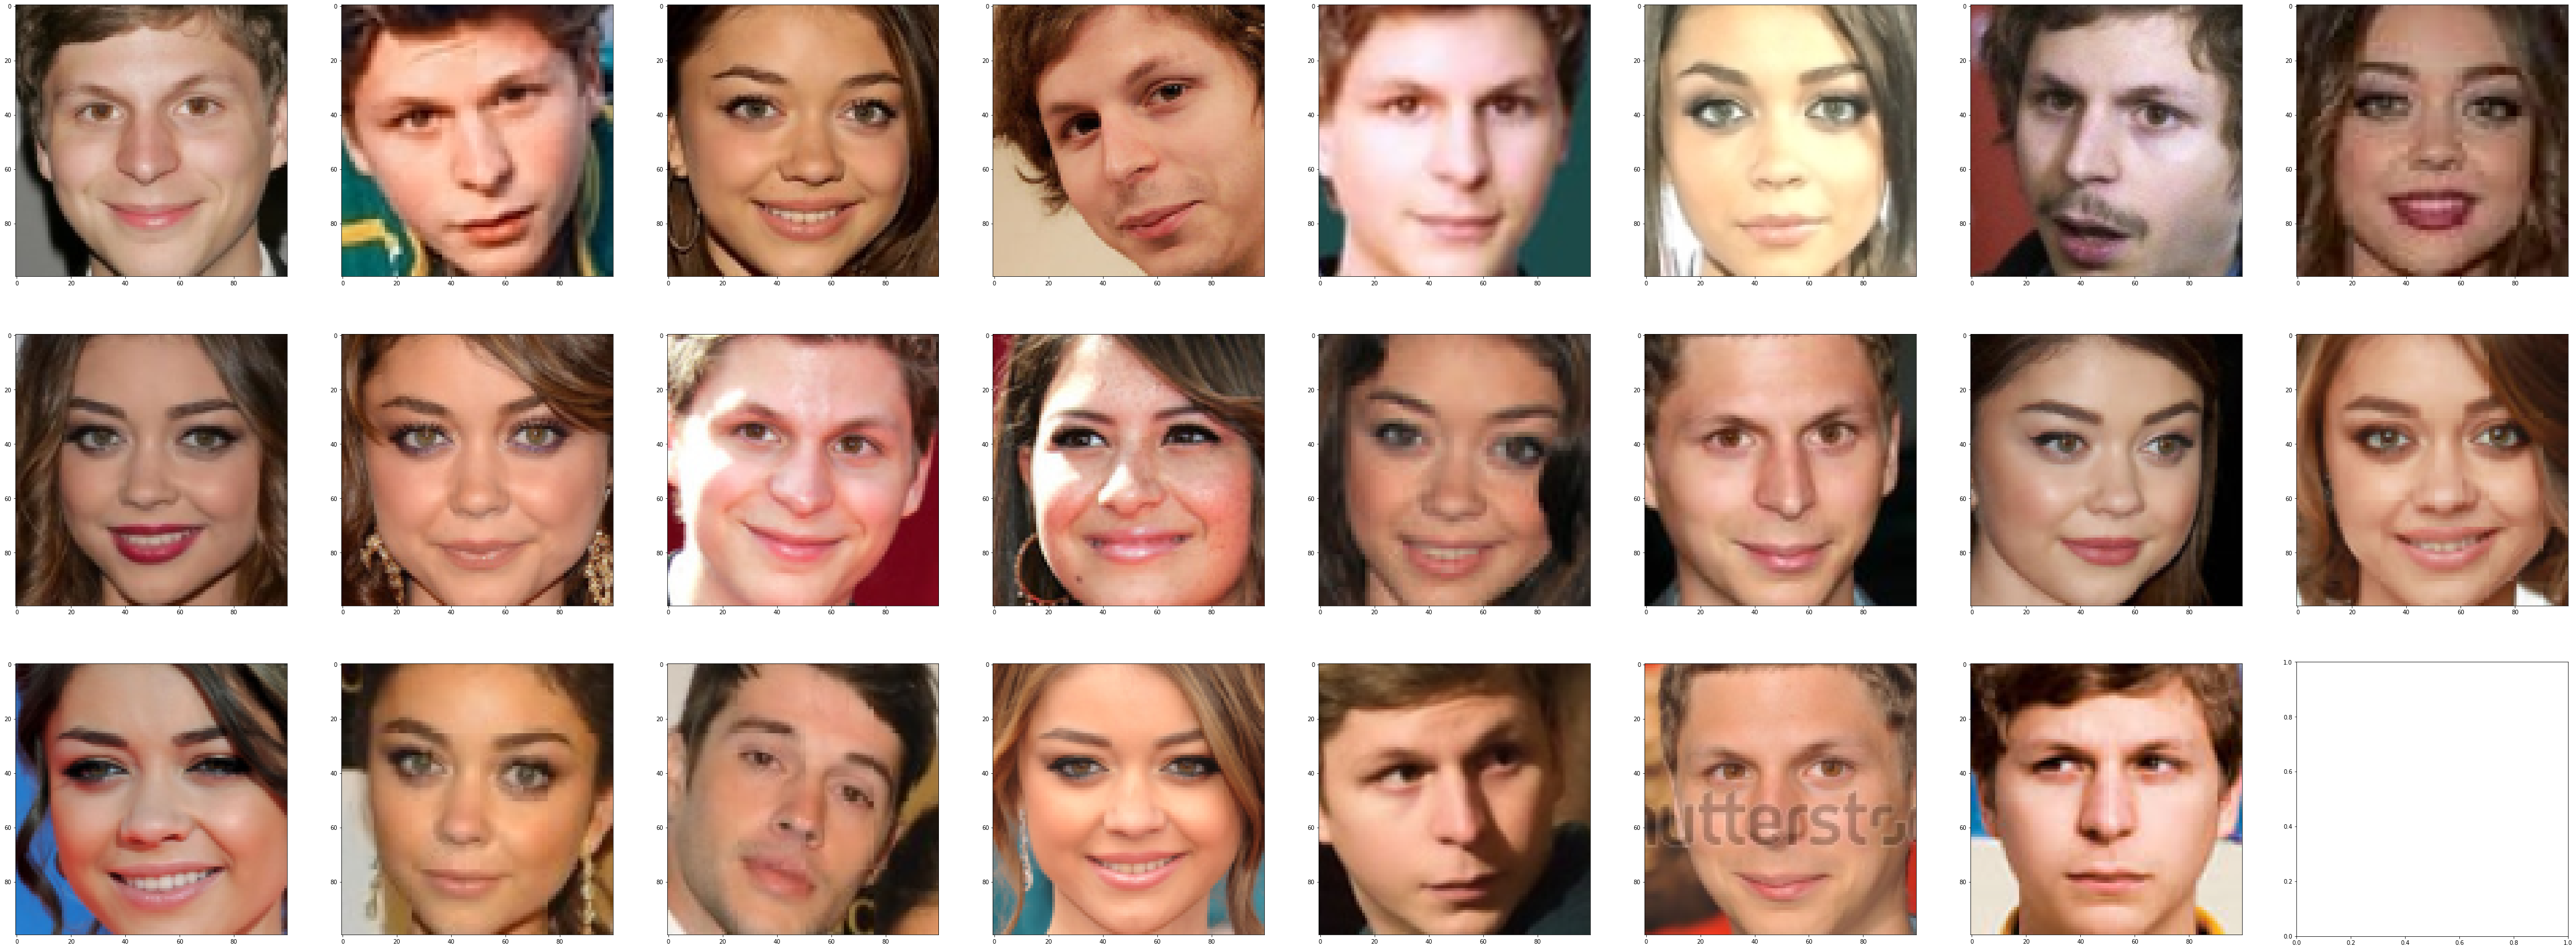

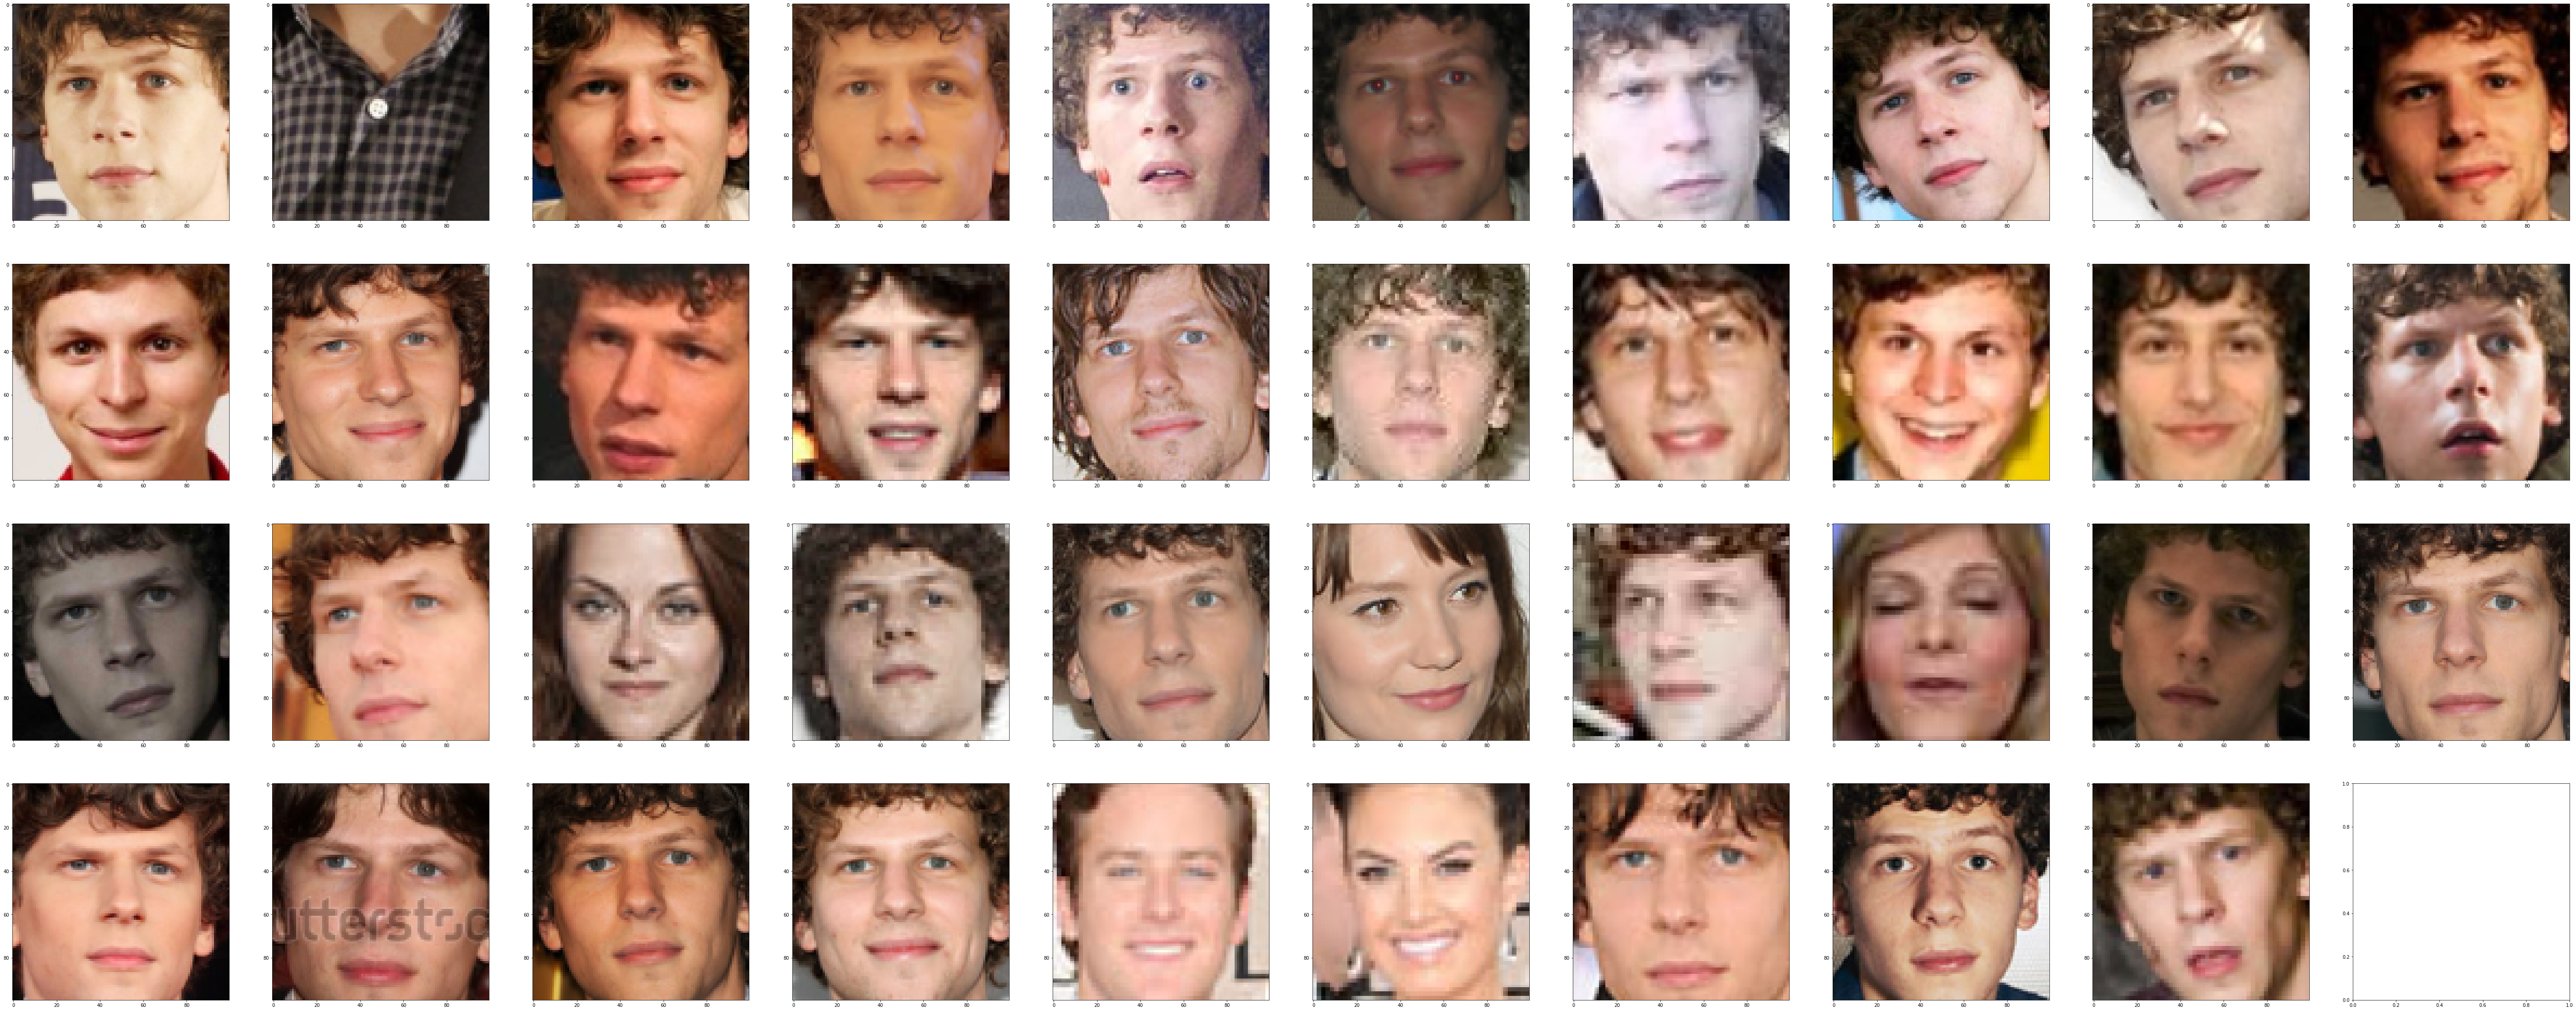

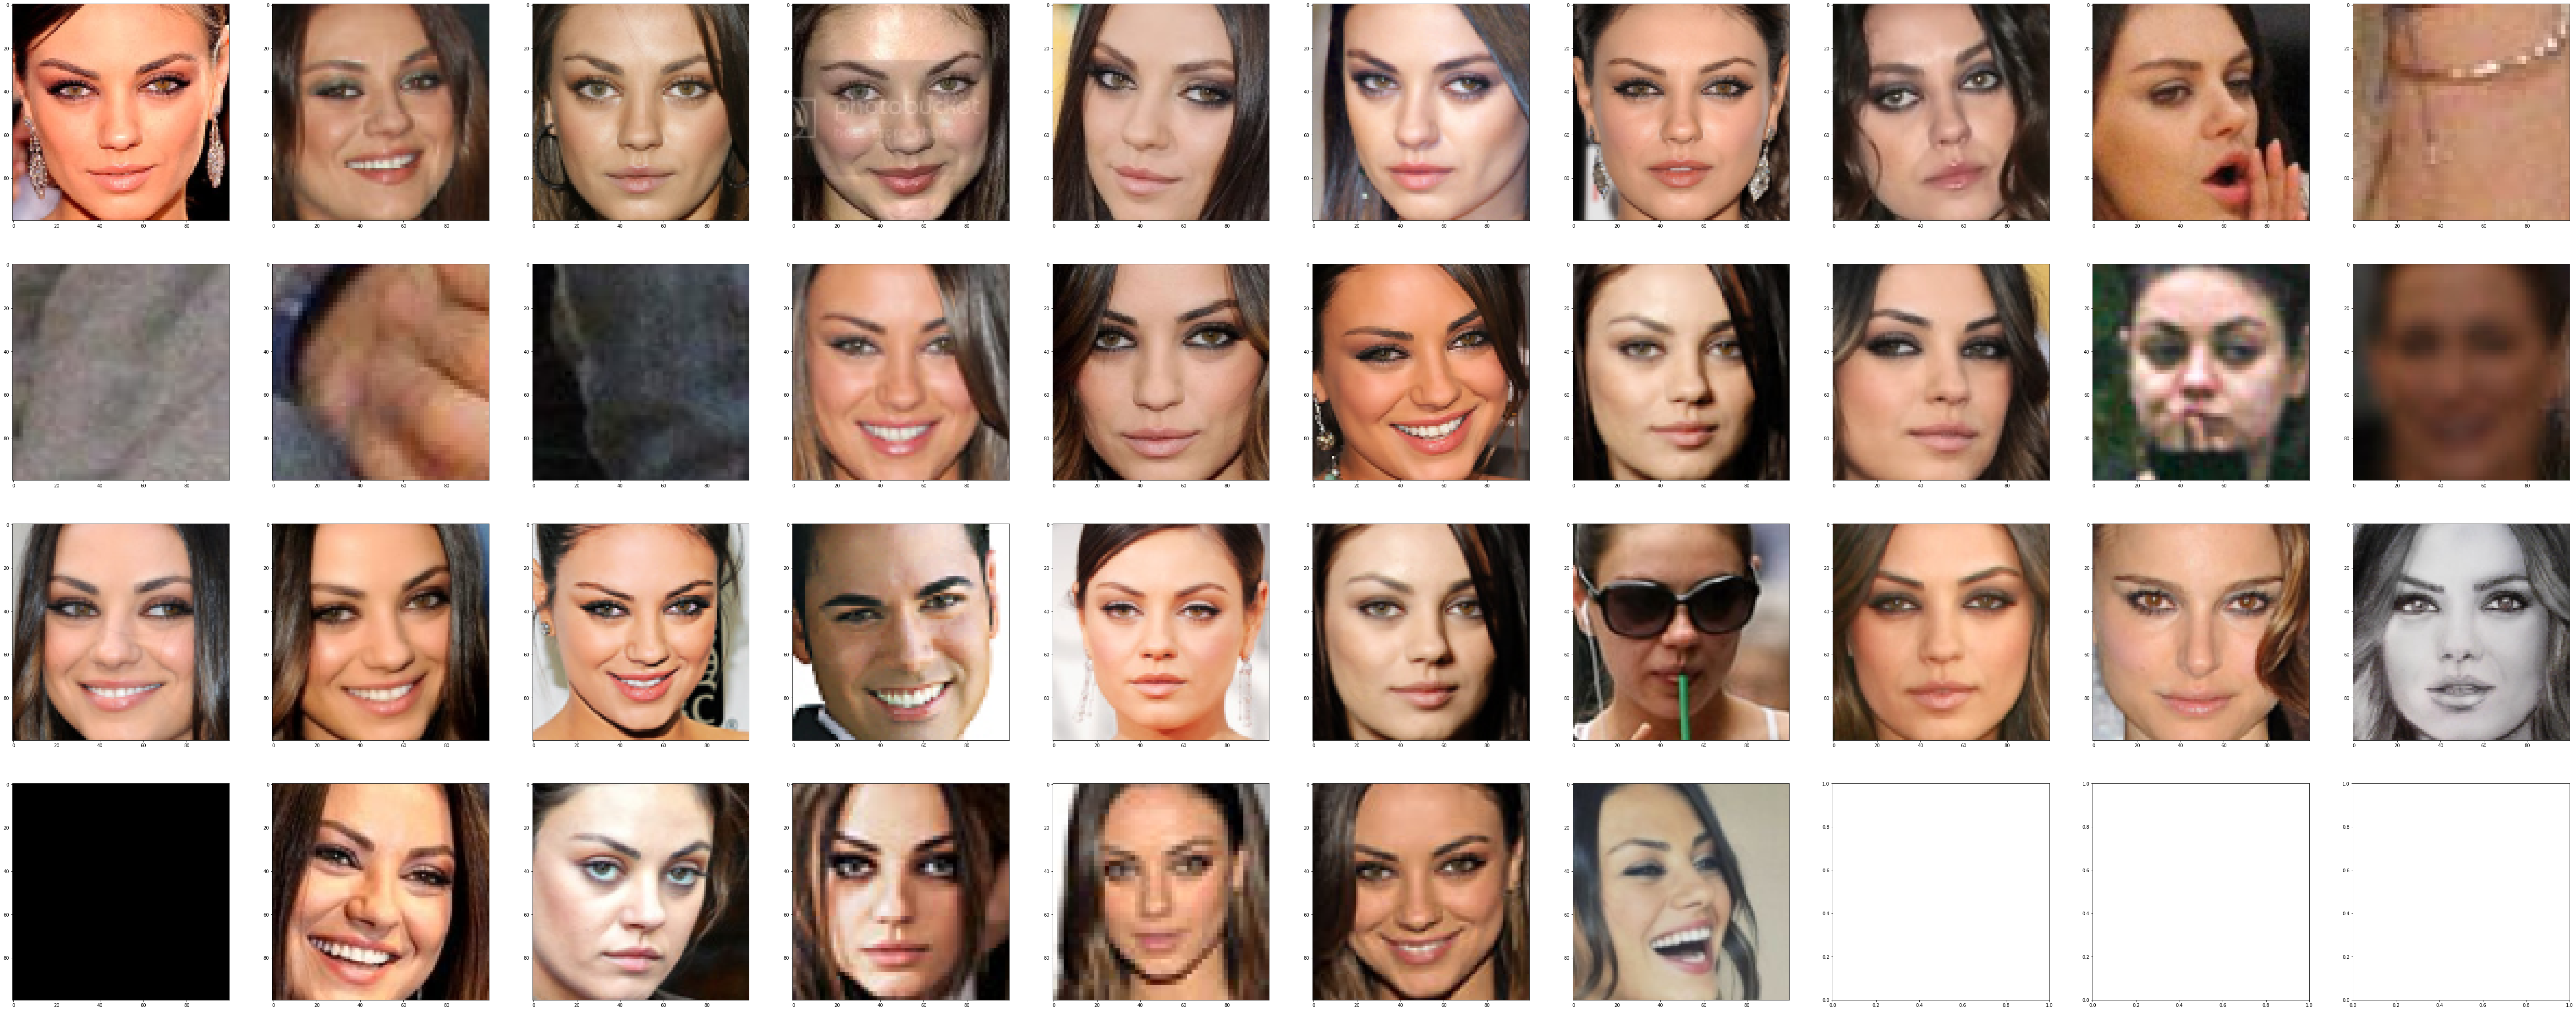

In [16]:
plot_image_sequence(train_X_V2[train_y_V2 == 0], n=23, imgs_per_row=8)

plot_image_sequence(train_X_V2[train_y_V2 == 1], n=39, imgs_per_row=10)

plot_image_sequence(train_X_V2[train_y_V2 == 2], n=37, imgs_per_row=10)

We create a different improved HAARPreprocessor class for testing data HAARPreprocessor_V2_test

It also improves the detection of images (in detect_faces()) by trying different parameters if no face was detected in order to avoid extracting no face at all 

However, it only keeps one face per image (first face detected) so that we keep the same size of the testing faces as required (1816). This is not ideal but we can try to improve it later

In [17]:
class HAARPreprocessor_V2_test():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=8,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
        if len(faces)==0:
            faces = self.classifier.detectMultiScale(
                img_gray,
                scaleFactor=1.2,
                minNeighbors=1,
                minSize=(30, 30),
                flags=cv2.CASCADE_SCALE_IMAGE
                )
            if len(faces)==0:
                faces = self.classifier.detectMultiScale(
                    img_gray,
                    scaleFactor=1.1,
                    minNeighbors=1,
                    minSize=(30, 30),
                    flags=cv2.CASCADE_SCALE_IMAGE
                    )
        return faces
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

We implement our improved HAARProcessor on the test data

In [18]:
preprocessor_test = HAARPreprocessor_V2_test(path = '../../tmp', face_size=FACE_SIZE)
test_X_V2 = preprocessor_test(test)

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [19]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
 
### 1.1.1. Scale Invariant Feature Transform (SIFT)

We will use Scale Invariant Feature Transform (SIFT) as a handcrafted feature extractor. 

SIFT identifies "good" local features by constructing a scale space so that these features are independant from scale, localizing distinct keypoints from the rest of the image to be considered a local feature, and assigning dominant orientations to localized keypoints making SIFT invariant to rotation.

Below we will set the class for the SIFT features extractor and the functions that we will use.

This first SIFT class is for training data.

In [20]:
class sift_features_train(): # Class for the SIFT features extractor
    
     # Function for convert images to grayscale for SIFT algorithm
    def gray(self, img_list): 
        return [cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2GRAY) for img in img_list]
    
     # Function that take list of images (in grayscale), extracts keypoints and descriptors using SIFT, 
     # and transforms it into an array of vectors for training based on a predetermined vector size
    def transform(self, img_list, labels, n_keypoints): # n_keypoints sets the keypoints per image, and length of vector to ensure the final array is of homogenous shape
        sift = cv2.SIFT_create() # create a SIFT instance
        vector_size = 128*n_keypoints # vector size for each vector of image keypoints. 
        kp_list = []
        des_list = []
        img_skipped = []
        training_data = np.array([])
        training_labels = np.array([])
        index = 0
        for img in img_list: # for each img in list of images
            keypoints, descriptors = sift.detectAndCompute(img,None) # extract keypoints and descriptors
            
            # configure data into convenient format for training 
            if len(keypoints) < 30: # if no keypoints were extracted from img, skip to next img
                img_skipped.append(index) # save index of images with no keypoints
                index += 1 # keep correct count of index despite skipped image
                continue            
            
            kp_list.append(keypoints) # append keypoints of each image
            des_list.append(descriptors) # append descriptors of each image
            
            if len(keypoints) < n_keypoints: # make up for images with less keypoints than the set treshold (n_keypoints)
                current_len = len(keypoints)
                descriptors_needed = n_keypoints - current_len # calculate how many descriptors needed
                repeated_descriptors = descriptors[0:descriptors_needed, :] # duplicate some of the descriptors to make up for descriptors needed
                while len(descriptors) < n_keypoints:
                    descriptors = np.concatenate((descriptors, repeated_descriptors), axis=0) # concatenate duplicate descriptors with with main descriptors to have a total of n_keypoints
            descriptors = descriptors.astype(np.float64)
            np.random.shuffle(descriptors) # shuffle descriptor order to not have bias in only keeping for n_keypoints descriptors
            descriptors = descriptors[0:n_keypoints,:] # trim excess descriptors for images with more than n_keypoints
            vector_data = descriptors.flatten() # flatten into 1D vector 
            
            # concatenate descriptors of each image into one vector (training_data)
            if len(training_data) == 0: # if training_data is still empty, then it equal the vector of the first image
                training_data = vector_data
            else: # concatenate the vectors of the following images into training_data
                training_data   = np.concatenate((training_data, vector_data), axis=0)
                
            training_labels = np.append(training_labels,labels[index]) # append label of the image
            
            index += 1 # keep correct count of index
        training_data = training_data.reshape(len(training_labels),vector_size) # reshape our 1D data vector into N dimensions for N number of images with more than 0 keypoints
        return kp_list, des_list, training_data, training_labels, img_skipped

Now, we will implement the sift_features class and use its functions to extract the sift features

In [21]:
n_keypoints = 100 # picking a value for the n_keypoints and eventual length of vector
sift_extractor = sift_features_train() # constructing an object of the class
train_gray = sift_extractor.gray(train_X_V2) # converting the list of images to grayscale
kp_list, des_list, training_data, training_labels, img_skipped = sift_extractor.transform(train_gray, train_y_V2, n_keypoints)

We remove the  skipped images from our data below

In [22]:
train_gray=np.delete(train_gray, img_skipped, axis=0)
train_X_V3=np.delete(train_X_V2, img_skipped, axis=0)

After extracting those features, we will try to visulize the keypoints on an image (e.g. the image number 0)

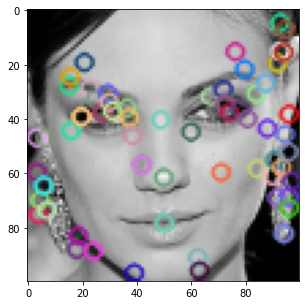

In [23]:
img = cv2.drawKeypoints(train_gray[0],kp_list[0],None) # draw the keypoints on top of the grayscale image
f,ax = plt.subplots(1,1, figsize=(5,5)) 
ax.imshow(img) # plotting

We can use keypoints in an image to match the found keypoints to keypoints found in another image using brute-force matching (BFMatcher)

[ WARN:0] global /tmp/pip-req-build-21t5esfk/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


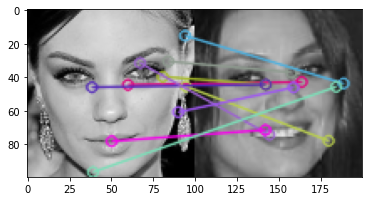

In [24]:
sift = cv2.xfeatures2d.SIFT_create() # create a SIFT instance 
keypoints1, descriptors1 = sift.detectAndCompute(train_gray[0],None) # extract keypoints and descriptors of the first image
keypoints2, descriptors2 = sift.detectAndCompute(train_gray[1],None) # extract keypoints and descriptors of the second image

bf = cv2.BFMatcher() # create a BFMatcher object
matches = bf.match(descriptors1, descriptors2) # extract matches between the two images' descriptors using BFMatcher

# The resulting matches are then filtered either on distance (matches above a certain distance from eachother are discarded) or by picking the best N number of matches.
matches = sorted(matches, key = lambda x: x.distance) # Order the matches by distance
match_img = cv2.drawMatches(train_gray[0], keypoints1, train_gray[1], keypoints2, matches[:10], None, flags=2) # Draw best 10 matches on the two images

plt.imshow(match_img) # plotting

We can also try using a different algorithm for matching keypoints between two images: FLANN (Fast Library for Approximate Nearest Neighbors) algorithm

FLANN is much faster than BFMatcher but it only finds an approximate nearest neighbor, which is a good matching but not necessarily the best

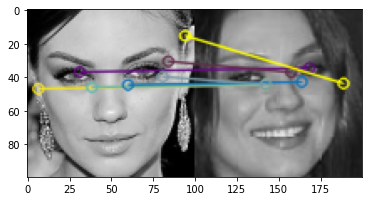

In [25]:
flann = cv2.FlannBasedMatcher() # create a FLANN object

matches = flann.knnMatch(descriptors1, descriptors2, k=2) # extract matches between the two images' descriptors using FLANN

# Here, instead of picking best N number of matches, we pick all matches under a certain distance (e.g. 0.8 which is a good threshold for FLANN)
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

# use the drawMatches funciton to see the result of the matching of keypoints
img = cv2.drawMatches(train_gray[0], keypoints1, train_gray[1], keypoints2,good,None, flags=2) # Draw the matches that meet our distance criterion on the two images
plt.imshow(img) # plotting

Now we can use the SIFT features matching to correct the mislabeled images in our training data

We run a loop with each image and compute the average number of matches under specific criteria with the rest of images corresponding to the same class

If the image does have enough matches, we give it the class label 0 of the imposter images

In [26]:
wrong_imgs=[]
for i in range(len(kp_list)):
    n_matches=[]
    descriptors1=des_list[i]
    if training_labels[i]==1:
        for x in range(len(kp_list)):
            if x != i and training_labels[x]==1:
                descriptors2=des_list[x]
                bf = cv2.BFMatcher() # create a BFMatcher object
                matches = bf.knnMatch(descriptors1, descriptors2, k=2)
                good = []
                for m,n in matches:
                    if m.distance < 0.76*n.distance:
                        good.append(m)
                n_matches.append(len(good))
        av_matches=np.mean(n_matches)
        if av_matches < 2:
            wrong_imgs.append(i)
    if training_labels[i]==2:
        for x in range(len(kp_list)):
            if x != i and training_labels[i]==2:
                descriptors2=des_list[x]
                bf = cv2.BFMatcher() # create a BFMatcher object
                matches = bf.knnMatch(descriptors1, descriptors2, k=2)
                good = []
                for m,n in matches:
                    if m.distance < 0.85*n.distance:
                        good.append(m)
                n_matches.append(len(good))
        av_matches=np.mean(n_matches)
        if av_matches < 4:
            wrong_imgs.append(i)


for x in wrong_imgs:
    training_labels[x]=0.0

In [27]:
train_X = train_X_V3
train_y = training_labels

Ce also create a SIFT class for testing data

In [28]:
class sift_features_test(): # Class for the SIFT features extractor
    
     # Function for convert images to grayscale for SIFT algorithm
    def gray(self, img_list): 
        return [cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2GRAY) for img in img_list]
    
     # Function that take list of images (in grayscale), extracts keypoints and descriptors using SIFT, 
     # and transforms it into an array of vectors for training based on a predetermined vector size
    def transform(self, img_list, n_keypoints): # n_keypoints sets the keypoints per image, and length of vector to ensure the final array is of homogenous shape
        sift = cv2.xfeatures2d.SIFT_create() # create a SIFT instance 
        vector_size = 128*n_keypoints # vector size for each vector of image keypoints. 
        kp_list = []
        des_list = []
        testing_data = np.array([])
      
        index = 0
        for img in img_list: # for each img in list of images
            keypoints, descriptors = sift.detectAndCompute(img,None) # extract keypoints and descriptors
            
            kp_list.append(keypoints) # append keypoints of each image
            des_list.append(descriptors) # append descriptors of each image
            
            # configure data into convenient format for training 
            if len(keypoints) == 0: # if no keypoints were extracted from img, fill with vector of zeros
                descriptors=np.zeros((n_keypoints, 128))        
            
            if len(keypoints) < n_keypoints: # make up for images with less keypoints than the set treshold (n_keypoints)
                current_len = len(keypoints)
                descriptors_needed = n_keypoints - current_len # calculate how many descriptors needed
                repeated_descriptors = descriptors[0:descriptors_needed, :] # duplicate some of the descriptors to make up for descriptors needed
                while len(descriptors) < n_keypoints:
                    descriptors = np.concatenate((descriptors, repeated_descriptors), axis=0) # concatenate duplicate descriptors with with main descriptors to have a total of n_keypoints
            descriptors = descriptors.astype(np.float64)
            
            np.random.shuffle(descriptors) # shuffle descriptor order to not have bias in only keeping for n_keypoints descriptors
            descriptors = descriptors[0:n_keypoints,:] # trim excess descriptors for images with more than n_keypoints
            vector_data = descriptors.flatten() # flatten into 1D vector 
            
            # concatenate descriptors of each image into one vector (testing_data)
            if len(testing_data) == 0: # if testing_data is still empty, then it equal the vector of the first image
                testing_data = vector_data
            else: # concatenate the vectors of the following images into testing_data
                testing_data   = np.concatenate((testing_data, vector_data), axis=0)
            # print (testing_data.shape)
            
            index += 1 # keep correct count of index
        testing_data = testing_data.reshape(index,vector_size) # reshape our 1D data vector into N dimensions for N number of images with more than 0 keypoints
        return kp_list, des_list, testing_data

In [29]:
n_keypoints = 100 # picking a value for the n_keypoints and eventual length of vector
sift_extractor = sift_features_test() # constructing an object of the class
test_gray = sift_extractor.gray(train_X_V2) # converting the list of images to grayscale
kp_list_train, des_list_train, test_data = sift_extractor.transform(test_gray, n_keypoints)

We use the SIFT features in order to improve the HAARProcessor for testing data

We pick all faces per image but we match them to our classes in training data. Based on that we only keep the best match

In [30]:
class HAARPreprocessor_V3_test():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=8,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
        if len(faces)==0:
            faces = self.classifier.detectMultiScale(
                img_gray,
                scaleFactor=1.2,
                minNeighbors=1,
                minSize=(30, 30),
                flags=cv2.CASCADE_SCALE_IMAGE
                )
            if len(faces)==0:
                faces = self.classifier.detectMultiScale(
                    img_gray,
                    scaleFactor=1.1,
                    minNeighbors=1,
                    minSize=(30, 30),
                    flags=cv2.CASCADE_SCALE_IMAGE
                    )
        return faces
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        elif len(faces) == 1:
            return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
        
        else:
            av_matches_1=[]
            av_matches_2=[]
            for idx in range(len(faces)):                
                face = faces[idx]
                gray_face = cv2.cvtColor(np.uint8(face), cv2.COLOR_RGB2GRAY)
                sift = cv2.xfeatures2d.SIFT_create() # create a SIFT instance 
                keypoints1, descriptors1 = sift.detectAndCompute(gray_face,None) # extract keypoints and descriptors of the first image
                n_matches_1=[]
                n_matches_2=[]
                for x in range(len(kp_list)):
                    
                    if training_labels[x]==1:
                        descriptors2=des_list[x]
                        bf = cv2.BFMatcher() # create a BFMatcher object
                        matches = bf.knnMatch(descriptors1, descriptors2, k=2)
                        good = []
                        for m,n in matches:
                            if m.distance < 0.8*n.distance:
                                good.append(m)
                        n_matches_1.append(len(good))
                    
                    elif training_labels[x]==2:
                        descriptors2=des_list[x]
                        bf = cv2.BFMatcher() # create a BFMatcher object
                        matches = bf.knnMatch(descriptors1, descriptors2, k=2)
                        good = []
                        for m,n in matches:
                            if m.distance < 0.8*n.distance:
                                good.append(m)
                        n_matches_2.append(len(good))

                av_matches_1.append(np.mean(n_matches_1))
                av_matches_2.append(np.mean(n_matches_2))
            

            max_m = max([max(av_matches_1),max(av_matches_2)])
            
            if max_m in av_matches_1:
                idx = av_matches_1.index(max(av_matches_1))
            else:
                idx = av_matches_2.index(max(av_matches_2))
            
            face=faces[idx]
        
        # only return the first face
        return cv2.resize(face, self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

In [31]:
preprocessor_test = HAARPreprocessor_V3_test(path = '../../tmp', face_size=FACE_SIZE)
test_X_V2 = preprocessor_test(test)

### 1.1.2. t-SNE Plots
We will use t-distributed stochastic neighbor embedding (t-SNE) to visualize the classification of the classes of images using our SIFT features

t-SNE is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 93 nearest neighbors...
[t-SNE] Indexed 94 samples in 0.001s...
[t-SNE] Computed neighbors for 94 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 94 / 94
[t-SNE] Mean sigma: 752.454657
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.481552
[t-SNE] KL divergence after 1000 iterations: 1.089618


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

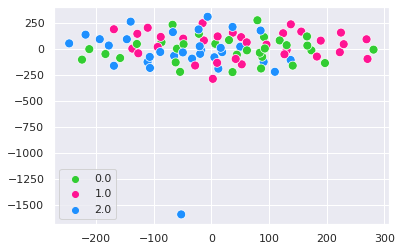

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne_em = TSNE(n_components=2, perplexity=40, n_iter=1000, verbose=1).fit_transform(training_data)

plt.clf()
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(tsne_em[:,0], tsne_em[:,1], hue=training_labels, s=80, palette={ 0: "limegreen", 1: "deeppink", 2: "dodgerblue"})


When visualizing the plot, we do not see any clear clusters. However, we can still see a little seperation between 1 (Jesse_Eisenberg) and 2 (Mila Kunis). The imposters (0) seem to be more dispersed over the scatter plot

We will set the color white to class 0 to better visualize the difference between the other two classes (1 and 2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

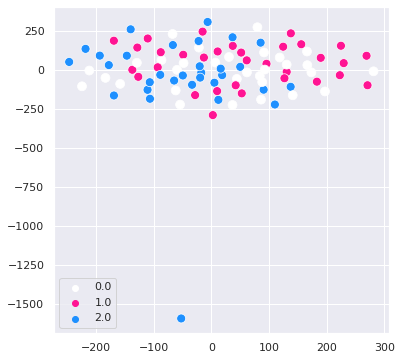

In [33]:
plt.clf()
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(tsne_em[:,0], tsne_em[:,1], hue=training_labels, s=80, palette={ 0: "white", 1: "deeppink", 2: "dodgerblue"})

### 1.1.3. Discussion

We don't get a good classification using t-SNE. We see very little clustering of blue dots and pink dots seperately but there aren't really any clear clusters. The SIFT features worked well with both the Flann and Brute-force matchers so the features must be robust. A different classification method could perform better.

## 1.2. Baseline 2: PCA feature extractor

Principal Component Analysis (PCA) is a technique that reduces dimensionality and it is usually performed by eigenvalue decomposition of the covariance matrix. Another technique of PCA is through Singular Value Decomposition (SVD) and it is the one performed by scikit learn's implementation. Necessary preprocessing steps before PCA involve normalizing both train and test datasets, in order for all variables to have the same standard deviation, and thus not different weight.

Also removing the mean image of all images will enhance the difference between images. It means that clean difference can be learned in a better way from the model.

Text(0.5, 1.0, 'mean image')

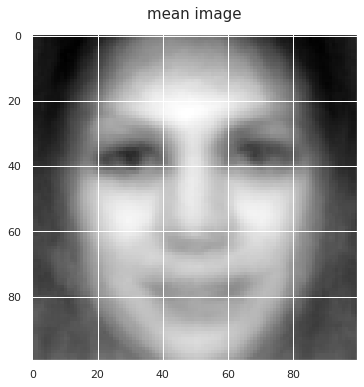

In [34]:
# Turn RBG images to grayscale
number_of_pixels = FACE_SIZE[0]*FACE_SIZE[1]

test_X_gray = [cv2.cvtColor(i.astype(np.uint8), cv2.COLOR_RGB2GRAY) for i in test_X]
train_X_gray = [cv2.cvtColor(i.astype(np.uint8), cv2.COLOR_RGB2GRAY) for i in train_X]

# The PCA algorithm takes as an input a vector per image
train_X_1d = np.reshape(train_X_gray, (len(train_X), number_of_pixels))
test_X_1d = np.reshape(test_X_gray, (len(test_X), number_of_pixels))

# Mean calculation of the train data, in order to use it for the standardarization of both the train and the test data.
mean = np.mean(train_X_1d, axis=0)
mean_im = mean.reshape([100,100])
plt.imshow(mean_im, cmap='gray')
plt.title('mean image', fontsize=15, pad=15)

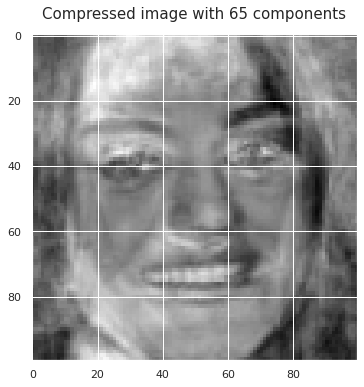

In [35]:
# We subtract the mean of the train data from both train and test data.
train_X_mean_subtracted = [i - mean_im for i in train_X_gray]
test_X_mean_subtracted = [i - mean_im for i in test_X_gray]

# We transform to vectors since it is needed for the PCA.
train_X_mean_subtracted_1d = np.reshape(train_X_mean_subtracted, (len(train_X), number_of_pixels))
test_X_mean_subtracted_1d = np.reshape(test_X_mean_subtracted, (len(test_X), number_of_pixels))

# Apply PCA. Initial experimentation with the number of Principal components. 
from sklearn.decomposition import PCA

n_components = 65
pca = PCA(n_components=65)
pca.fit(train_X_mean_subtracted_1d)
pca_transformed = pca.transform(train_X_mean_subtracted_1d)
pca_recovered = pca.inverse_transform(pca_transformed)

image_pca = pca_recovered[1,:].reshape([100,100])
plt.imshow(image_pca, cmap='gray')
plt.title('Compressed image with {} components'.format(n_components), fontsize=15, pad=15)
plt.savefig("image_pca_10.png")


Text(0.5, 1.0, 'image with mean subtracted')

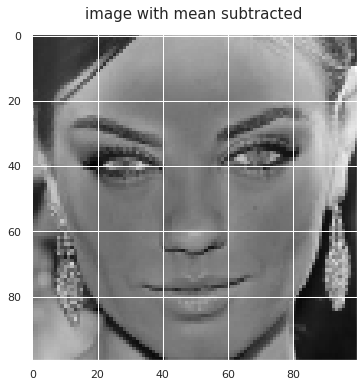

In [36]:
# We plot one of the images with subtracted mean, to see how they look like!
train_X_mean_subtracted[0]
plt.imshow(train_X_mean_subtracted[0], cmap='gray')
plt.title('image with mean subtracted', fontsize=15, pad=15)

Let's try now to plot the same image using different number of principal components! 
As shown below, using many principal components, that correspond mathematically to eigenvectors, we reconstruct the image really well, whereas for lower number of principal components the image is more blurry. Remember to take care with the mean to really reconstruct the image.

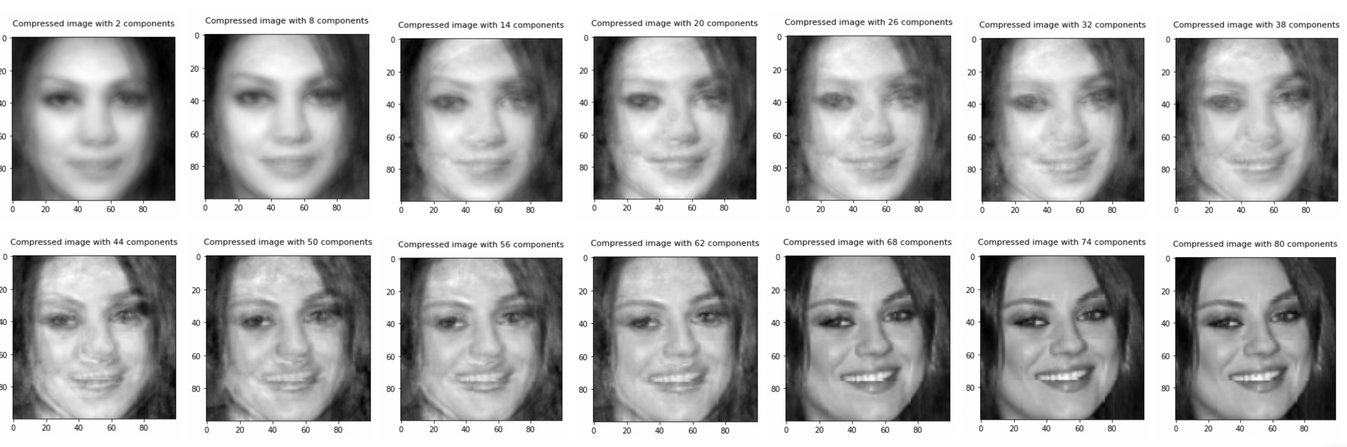

In order to see how many principal components are optimal to be used in order not to lose useful information and 
at the same not have information that is not needed. By plotting the explained variance ratio compared to the number of components used and knowing that at least 97% approximately of the train data should be explained, we assume that there is no reason to use more than 60 principal components, since that will be more informative.

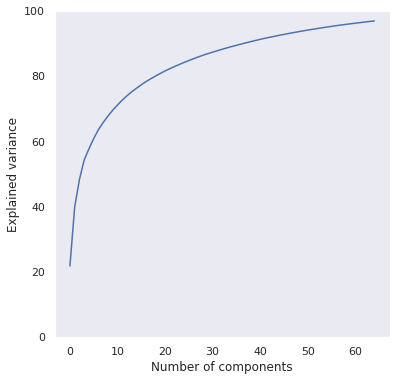

In [37]:
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.ylim([0, 100])
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

From the diagram above, we can see that having above around 65 components does not increase more the variability.
It looks quite optimal already with 60 principal components.

### EigenFaces Space

Projection of all the original images onto the first two principal components.
We can see the difference in the images plot region, where it is noticiable the outliers, while the normal images are ploted in a more proximity region. Also it is a bit separeted by the person in the photo.

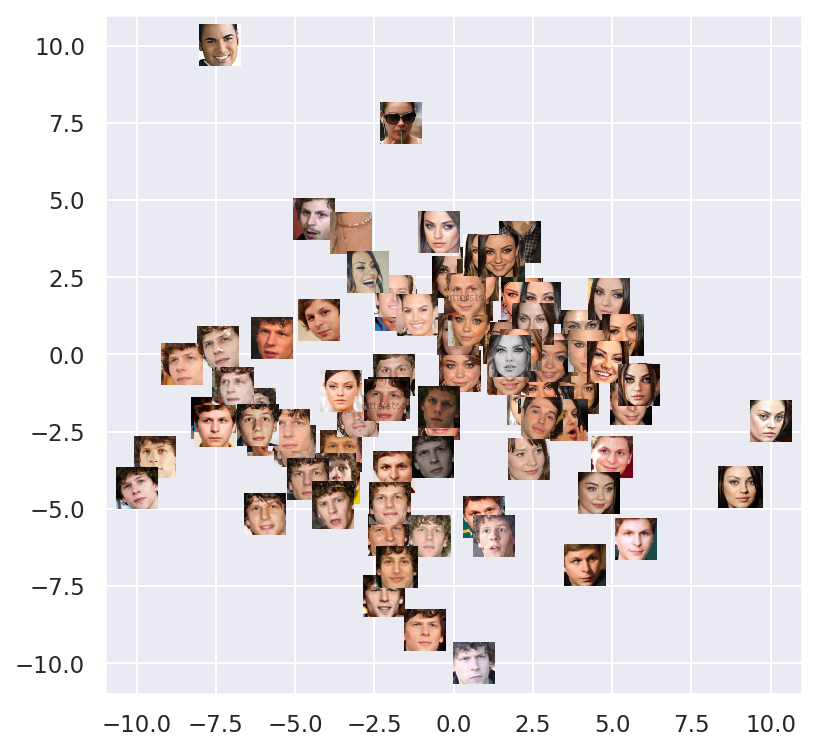

In [38]:
from sklearn.preprocessing import minmax_scale
from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg


pca = PCA(n_components=2)
pca_fit = pca.fit(train_X_mean_subtracted_1d.T)

positions = minmax_scale(pca_fit.components_.T, feature_range=(-10,10))

fig, ax = plt.subplots()
fig.set_dpi(150)

ax.set_xlim(-11, 11)
ax.set_ylim(-11, 11)

for pos, img in zip(positions, train_X):
    imagebox = OffsetImage(img, zoom=0.2)
    ab = AnnotationBbox(imagebox, pos, frameon=False)
    ax.add_artist(ab)
    plt.grid()
plt.draw()
plt.show()

EigenFaces project based on the reconstructed images onto the first two principal components. 
The same idea of the previous plot, but now based on the reconstructed images.

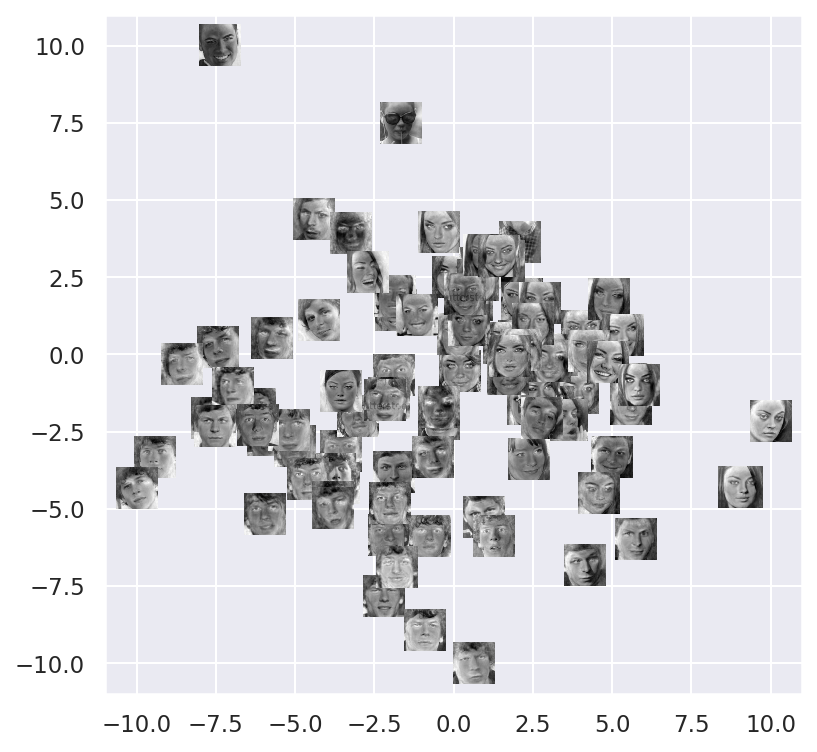

In [39]:
fig, ax = plt.subplots()
fig.set_dpi(150)

ax.set_xlim(-11, 11)
ax.set_ylim(-11, 11)

for pos, img in zip(positions, pca_recovered):
    img = img.reshape([100,100])
    imagebox = OffsetImage(img, cmap='gray', zoom=0.2)
    ab = AnnotationBbox(imagebox, pos, frameon=False)
    ax.add_artist(ab)
    plt.grid()
plt.draw()
plt.show()

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. 
Informally, accuracy is the proportion of correct predictions over the total amount of predictions. 
It is used a lot in classification but it certainly has its disadvantages...

Two key evaluation metrics are considered:

Root Mean Square Error: takes a square root of the mean square error.
Pros:
-Fast and simple computation
-Less penalty on errors during training

Cons:
-Highly dependent on the data scale and normalizations used
-Sensitive to outliers


Accuracy: an equivalent of top_k_categorical_accuracy is used.
The reverse one-hot-encoding process as explained earlier provides a simplified version of binary accuracy between the classes. 

Pro:
- Simple and intuitive evaluation Con
- Sensitive to errors

In [40]:
from sklearn.metrics import accuracy_score

##     Pre-Classification

Scaling the data towards .. helps to.... Here, the standard Scaler of Sklearn is applied to ....Scale down to 0 mean and sigma = 1 for

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Fit on training set only.
scaler.fit(train_X_mean_subtracted_1d) # Apply transform to both the training set and the test set.
train_img = scaler.transform(train_X_mean_subtracted_1d)
test_img = scaler.transform(test_X_mean_subtracted_1d)

In [42]:
from sklearn.decomposition import PCA# Make an instance of the Model
# You can either choose the explained variance by setting svd_solver = ‘full’ and PCA between (0,1)
# e.g. pca = PCA(n_components = 0.97, svd_solver = 'full') for explained variance 97%
# Or you can choose the number of components
pca = PCA(n_components = 60)

## Fit PCA on the training set

In [43]:
pca.fit(train_img)

PCA(n_components=60)

## Check how much variance of data is explained, if you chose specific number of components.

In [44]:
np.sum(pca.explained_variance_ratio_)

0.958989443512215

## Transform both datasets, using the PCA Model.

In [45]:
X_train = pca.transform(train_img)
X_test = pca.transform(test_img)

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [46]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

The images will be classified based upon their features. Several techniques can be used for this. 
We experiemented with Random Forest, Logistic Regression, Neural Networks and Support Vector Machines. 

PCA features have been testes with: Random Forest, Logistic Regression , Neural Networks and Support Vector Machines. 
SIFT Features have been tested with Support, Vector Machines and Neural Networks 

Training an SVM classification model with the help of GridSearch in order to find the best hyperparameters. The best parameters found are printed below. 

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = { 'C': [0.1, 1, 10, 100, 1000],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train, train_y)

print("Best Estimator found by Grid Search:")
print(clf.best_estimator_)

Best Estimator found by Grid Search:
SVC(C=10, class_weight='balanced', gamma=0.0001)


We use k-fold to test the training accuracy of the model

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

training_labels_clf = train_y

# evaluate model
scores = cross_val_score(clf, X_train, training_labels_clf, scoring='accuracy', cv = 10, n_jobs=-1) #cv = cv
# report performance
print(scores.mean())
print(scores.std())

####################
y_pred = clf.predict(X_test)
rbf_y_test = y_pred

0.7555555555555556
0.13212414663284222


## One-hot endoding for PCA

In [49]:
# One-hot encoding for tranformation of the classes on PCA features
# A Deep Learning model is used as a multiclass classifier.

# The model is trained against a training set (input) and training labels (three classes used as output: 0, 1, 2)
# The output classes are first One-Hot-Encoded in order to improve the training of deep learning model


from keras.utils.np_utils import to_categorical   
train_yOHE = to_categorical(train_y, num_classes=3, dtype='int') 
print('train_yOHE',len(train_yOHE))
print('train_y',len(train_y))
train_yOHE.shape

train_yOHE 94
train_y 94


(94, 3)

## Classification with Neural networks on PCA 

In [50]:
# First Neural Network on PCA input data
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense


# Model with 5 hidden layers is chosen
# The combination of selected activation functions, loss function and optimizer are found to produce best results.

model = Sequential()
model.add(Dense(60, input_dim=60, activation='relu'))# set input dim= n, n_components of PC's selected for pca_2 = PCA(n_components=60)
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(3, activation='softmax')) # 3 nodes of Dense layer corresponding to three classes one-hot-encoded
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, train_yOHE, epochs=10, verbose=1)

2022-04-12 22:55:09.348628: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-12 22:55:09.549512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
3/3 [==============================] - 1s 7ms/step - loss: 1.0418 - accuracy: 0.3298
Epoch 2/10
3/3 [==============================] - 0s 6ms/step - loss: 0.6448 - accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 0s 6ms/step - loss: 0.5894 - accuracy: 0.4894
Epoch 4/10
3/3 [==============================] - 0s 5ms/step - loss: 0.5035 - accuracy: 0.6489
Epoch 5/10
3/3 [==============================] - 0s 5ms/step - loss: 0.4430 - accuracy: 0.7766
Epoch 6/10
3/3 [==============================] - 0s 5ms/step - loss: 0.3964 - accuracy: 0.8191
Epoch 7/10
3/3 [==============================] - 0s 5ms/step - loss: 0.3420 - accuracy: 0.8404
Epoch 8/10
3/3 [==============================] - 0s 5ms/step - loss: 0.2872 - accuracy: 0.9149
Epoch 9/10
3/3 [==============================] - 0s 4ms/step - loss: 0.2404 - accuracy: 0.9468
Epoch 10/10
3/3 [==============================] - 0s 5ms/step - loss: 0.1977 - accuracy: 0.9468


In [51]:
#Now used the model to predict classes from the given test data set, X_test

ANN_predict = model.predict(X_test)
print(ANN_predict.shape)

#However, the Deep Learning model delivers continuous float data type output at all three indeses of the output array.
#The output is converted equilent to one-hot-encoding by finding the index of maximum magnitude, rest taken as zero.
#The resulting reshape corresponds to a one-hot-encoding of output similar to performed before training the model.
#This is done to compare the accuracy and further generate a csv file containing class labels: 0, 1, 2 in the original form

annOutput = (ANN_predict).argmax(axis=1)

annOutput_short= annOutput[:120] #checking accuracy against the first 120 images from test set.
#print(annOutput_short.shape)
# print(train_y[-10:])

(1816, 3)


#NN with modifications on the layers for PCA

In [52]:
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from os.path import join
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(Dense(60, input_dim=60,kernel_initializer='random_normal',  activation='relu'))# set input dim= n, n_components of PC's selected for pca_2 = PCA(n_components=70)
model.add(Dense(100, kernel_initializer='random_normal', activation='relu'))
# model.add(Dense(40, activation='relu'))
# model.add(Dense(40, activation='relu'))
model.add(Dense(3,activation='softmax'))

opt = opt = Adam(learning_rate=0.07)
# opt = RMSprop(0.003) # 0.07
model.compile(loss='binary_crossentropy',  metrics=['accuracy'], optimizer=opt)
model.fit(X_train, train_yOHE, epochs=50, verbose=1)

Epoch 1/50
3/3 [==============================] - 1s 5ms/step - loss: 6.2470 - accuracy: 0.4574
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 0.6640 - accuracy: 0.7234
Epoch 3/50
3/3 [==============================] - 0s 4ms/step - loss: 0.5552 - accuracy: 0.7340
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3286 - accuracy: 0.8085
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2421 - accuracy: 0.8404
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1712 - accuracy: 0.9043
Epoch 7/50
3/3 [==============================] - 0s 4ms/step - loss: 0.1850 - accuracy: 0.9149
Epoch 8/50
3/3 [==============================] - 0s 4ms/step - loss: 0.1262 - accuracy: 0.9574
Epoch 9/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0936 - accuracy: 0.9681
Epoch 10/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0837 - accuracy: 0.9894
Epoch 11/50
3/3 [======================

In [53]:
ANN_predict = model.predict(X_test)

# print(ANN_predict)
print(ANN_predict.shape)
ANN_predict = model.predict(X_test)

annOutput = (ANN_predict).argmax(axis=1)
# take first 120 rows of output 
# take first 120 rows of labels 
annOutput_short= annOutput[:120]

(1816, 3)


## Random Forest Classifier with PCA

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, train_y)
rf_result=rf.predict(X_test)
rf_result= rf_result[:120]
# score missing!

# Several tryouts of Support Vector Machines

In [55]:
from sklearn import svm
# First tests with C fixed to 1
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, train_y)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, train_y)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, train_y)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, train_y)

In [56]:
linear_y_test = linear.predict(X_test)
rbf_y_test = rbf.predict(X_test)
poly_y_test = poly.predict(X_test)
sig_y_test = sig.predict(X_test)
rf_y_test = rf.predict(X_test)
print(linear_y_test)

[1. 0. 0. ... 0. 0. 0.]


In [57]:
rf_y_test = rf.predict(X_test)

## Classification with SIFT FEATURES 


### Random Search with SVM

A hyperparameter Search wit RandomizedSearchCV was applied to identify the best parameters for a SVM model based on SIFT feature data. 

In [58]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm

## Hyperparameter Tuning 
# run randomized search
n_iter_search = 100
C_range = (0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 50, 70, 90, 100)
kernels= ( 'rbf', 'poly', 'sigmoid', 'linear')
gamma_v    = (0.001, 0.01, 0.1, 1, 10, 100)


# build a regressor
svc_search = svm.SVC( decision_function_shape='ovo')
# specify parameters and distributions to sample from
param_dict = dict(C=C_range, kernel=kernels, gamma =  gamma_v)

random_search = RandomizedSearchCV(svc_search, param_distributions=param_dict, 
                                   error_score ='raise',  n_iter=n_iter_search, 
                                   cv=5, refit=True)

random_search.fit(training_data, training_labels)
random_search.cv_results_

{'mean_fit_time': array([0.04525447, 0.06618137, 0.04493523, 0.04601269, 0.04463391,
        0.04452224, 0.04439616, 0.08514442, 0.0840116 , 0.08261642,
        0.04716477, 0.0453259 , 0.04438653, 0.04511857, 0.04501901,
        0.04557605, 0.04503703, 0.04455214, 0.04431839, 0.04519477,
        0.04500737, 0.04489937, 0.04624033, 0.04414349, 0.0445262 ,
        0.04678898, 0.04474916, 0.04644556, 0.04552865, 0.04445548,
        0.0452724 , 0.04966679, 0.04657631, 0.06830544, 0.04379358,
        0.04591584, 0.04547625, 0.04399447, 0.04430189, 0.04462667,
        0.0436367 , 0.04379392, 0.04358439, 0.04504757, 0.04511614,
        0.0443717 , 0.04490166, 0.04489264, 0.04441562, 0.04402924,
        0.04461365, 0.04410224, 0.04445152, 0.04484196, 0.04589977,
        0.04531894, 0.04573221, 0.04465604, 0.04504499, 0.04502292,
        0.04524117, 0.04519382, 0.04392695, 0.0442009 , 0.04485817,
        0.04550185, 0.0471487 , 0.04701266, 0.04401107, 0.04362741,
        0.04422889, 0.06640148,

In [59]:

from sklearn import svm
poly = svm.SVC(kernel='linear',C=0.001, gamma=0.01, class_weight='balanced', decision_function_shape='ovo')
poly= poly.fit(training_data, training_labels)
poly_test1 = poly.predict(test_data)

## One-hot enconding for a Neural Network

The feature representations for the features of SIFT have the following input form: 
after the one hot encoding, the sift features have the following form (rows, 3). 
Thus there are columns that define the different classes to be set. 

In [60]:
from keras.utils.np_utils import to_categorical   
train_yOHESIFT = to_categorical(training_labels, num_classes=3, dtype='int')
#print(train_yOHE)

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from os.path import join
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, Model, layers
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# kf = KFold(n_splits=5)
# # kf.get_n_splits(training_data)
# k = 5

# evaluate model
# scores = cross_val_score(clf, training_data_new, training_labels, scoring='accuracy', n_jobs=-1) #cv = cv
# # report performance
# print(scores.mean())
# print(scores.std())


feature_layer = Input(12800)
# len(X_train_normalized.keys()
initializer = keras.initializers.RandomNormal(stddev=0.001) # HeNormal(seed=1)
activ = 'relu'# 

layer1 = layers.Dense(7000, kernel_initializer=initializer, activation=activ)(feature_layer)
# layer2 = layers.Dense(2000, kernel_initializer=initializer, activation=activ)(layer1)
# layer3 = layers.Dense(2000, kernel_initializer=initializer, activation=activ)(layer2)
# layer4 = layers.Dense(1000, kernel_initializer=initializer, activation=activ)(layer3)
layer5 = layers.Dense(1000, kernel_initializer=initializer, activation=activ)(layer1)
output = layers.Dense(3, kernel_initializer=initializer, activation='softmax')(layer5) # lookup
model = Model(inputs=feature_layer, outputs=output)

# optimize_RMS = RMSprop(0.001)
# optimize_adam = Adam(0.001) 
model.compile(loss='mse',  metrics=['mse'])

model.fit(training_data,train_yOHESIFT)
pred_values = model.predict(test_data)
    
nnOutput =  pred_values  # (pred_values).argmax(axis=1)


3/3 [==============================] - 2s 411ms/step - loss: 0.3805 - mse: 0.3805


## Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=5000)

# train the model
clf.fit(X_train, train_y)

# make predictions on the test data
preds = clf.predict(X_test)
test_y_star = preds.astype('int64')

# 5. Publishing best results

In [63]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

class
id         
0         1
1         2
2         0
3         1
4         1
...     ...
1811      0
1812      2
1813      0
1814      0
1815      0

[1816 rows x 1 columns]

In [64]:
submission.to_csv('submission.csv')

# 6. Discussion

We learned that there are different methods for feature extraction, there are different ways to extract the features. 
PCA was used to reduce dimensionality while preserving original information. However, we found that the technique deteriorated classifier 
performance when the number of principal components was chosen below 60 for a data set of only 80 images. 
This points to the fact that original data was high dimensional and requires additional preprocessing measures, as included in the code above.

PCA worked best with the deep learning model.

SIFT appears invariant to data preprocessing choices including scale, transpose or rotation. 
It also produced limited impact on the classification performance when images were enhanced or specific features were illuminated between contrasting pixels.
SIFT worked best with the SVM-Poly and SVM-RBF classifiers.

Why is a performance sub-optimal? 
The features extracted with the SIFT method have 12800 columns. Whereas these extracted features might provide superior classification results, 
Neural Networks on based on the latter are associated with problems. Given the datas dimensionality, the Neural network has 12800 input features in our case
For a fast result, this is not ideal.
In general, some classificaton scores were below 0.6%. This essentially means that the probability for an image to be classified correctly is not sufficiently 
high and this is therefore not a reliable model.  

In general, the classification algorithms based on the PCA features perform with higher accuracy than the ones on the SIFT features. 

What would you do better/more if you would have plenty of time to spend on each step?
- Improve preprocessing of the images, intensify work on feature enhancement
- Fit the Neural Network better to the underlying data, experiment especially with the number of hidden layers and nodes contained
- Setup of a Convolutional Neural Network, which would have provided better results that what we achieved with PCA and SIFT. However, a CNN requires extensive time on parameter tuning and 
would be compatible with  SIFT processing. In general, we would have needed less preprocessing of the input data. Also, CNN works well with hih, dimensional input data - such as the SIFT features we created. 

In summary we contributed the following: 
- WE have transformed the HARR preprocessing
- We extracted features of the images with PCA and SIFT feature extraction
- We enhanced the features for SIFT 
- We enhanced the features for PCA
- We applied Random Fores, Logistic Regression, Neural Networks and SVM as classification algorithms
- We worked towards continuously improving these results.

# 7. Tried Improvements 

After our implementation of image classification, we identified the following possibilities to improve the classification further: 

- Improve the HAARProcessor for both tesing and training data

- Implementing the SIFT features with HAARProcessor for better processing and labeling of training data
     
- Use another face detector, such as the MTCNN which is provided below

- Improve the detection, but continue getting some 'second' faces (not the principal one).
       
- Flipping and Enhancing the train images to get more and distinctive images.

- Using search grid to find the best parameters for the classification models and identify the optimal number of hidden layers, nodes in the layers

- Other improvements in the learning rate, initialization and activation methods
  

#### MTCNN face detector:

In [65]:

# class FaceDetectorMTCNN():
#     """Preprocessing pipeline built with MTCNN classifiers. """
    
#     def __init__(self, face_size):
#         self.face_size = face_size
        
#         self.classifier = MTCNN()

            
#     def detect_faces(self, img):
#         """Detect all faces in an image."""
#         detection = self.classifier.detect_faces(img)
#         if detection:
#             return [detection[0]["box"]]
#         return []
            

#     def extract_faces(self, img):
#         """Returns all faces (cropped) in an image."""
#         faces = self.detect_faces(img)
#         return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    
#     def preprocess(self, data_row):
#         faces = self.extract_faces(data_row['img'])
        
#         # if no faces were found, return None
#         if len(faces) == 0:
#             nan_img = np.empty(self.face_size + (3,))
#             nan_img[:] = np.nan
#             return nan_img
        
#         return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
#     def __call__(self, data):
#         return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)
    


#### Flipping and Enhancing the train images to get more and distinctive images.

In [66]:
# flipped_images_train_X = [cv2.flip(i.astype(np.uint8), flipCode = 1)
#                 for i in train_X]

To do the enhancement we follow a little tutorial found in the web.

In [67]:

# def enhancing_images(image, clip_hist_percent=1):
#     if not image.any():
#         return image
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
#     hist = cv2.calcHist([gray],[0],None,[256],[0,256])
#     hist_size = len(hist)
    
#     accumulator = []
#     accumulator.append(float(hist[0]))
#     for index in range(1, hist_size):
#         accumulator.append(accumulator[index -1] + float(hist[index]))

#     maximum = accumulator[-1]
#     clip_hist_percent *= (maximum/100.0)
#     clip_hist_percent /= 2.0

#     minimum_gray = 0
#     while accumulator[minimum_gray] < clip_hist_percent:
#         minimum_gray += 1
    
#     maximum_gray = hist_size -1
#     while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
#         maximum_gray -= 1
    
#     alpha = 255 / (maximum_gray - minimum_gray)
#     beta = -minimum_gray * alpha
  

#     auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
#     return (auto_result) 



In [68]:

# enhanced_images_train_X = [enhancing_images(i.astype(np.uint8))
#                 for i in train_X]



This code, save as the train X the normal images, the flipped and also the enhanced ones, respecting the order of the images. (80 normal, 80 flipped and 80 enhanced). 

Fot the train y we just concatenate the same data 3 times, to have the same size of train_X

In [69]:

# train_X = np.concatenate((train_X, flipped_images_train_X, enhanced_images_train_X))
# train_Y = np.hstack((train_y, train_y, train_y))
